In [1]:
# Cell 1: imports & helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("Library siap.")

Library siap.


In [2]:
# Cell 2: Environment class untuk "Agen Mengatur Stok Barang Sederhana"

class InventoryEnv:
    """
    Environment diskrit sederhana:
    - State: 0=Rendah (0-2), 1=Sedang (3-5), 2=Tinggi (6-8)
    - Actions: 0=Pesan Banyak (+2), 1=Pesan Sedikit (+1), 2=Tidak Pesan (-1)
    - Reward: +5 (Sedang), -10 (Kosong), -3 (Berlebih)
    - Episode ends when steps >= max_steps (episodik)
    """
    def __init__(self, max_steps=10, seed=None):
        self.max_steps = max_steps
        self.step_count = 0
        self.state = None
        if seed is not None:
            np.random.seed(seed)
    
    def reset(self, init_state=None):
        """Set awal state. Jika None, pilih acak dari 0..2"""
        self.step_count = 0
        if init_state is None:
            self.state = np.random.choice([0,1,2])
        else:
            self.state = int(init_state)
        return self.state
    
    def get_reward(self, state):
        if state == 0:
            return -10
        elif state == 1:
            return +5
        else:
            return -3
    
    def step(self, action):
        """
        action: 0,1,2
        returns: new_state (int), reward (float), done (bool)
        """
        # apply action: change "stock level index" (we clamp to [0,2])
        if action == 0:      # Pesan Banyak -> +2
            new_state = self.state + 2
        elif action == 1:    # Pesan Sedikit -> +1
            new_state = self.state + 1
        else:                # Tidak Pesan -> -1 (stok terjual)
            new_state = self.state - 1
        
        new_state = max(0, min(new_state, 2))
        reward = self.get_reward(new_state)
        
        self.step_count += 1
        done = (self.step_count >= self.max_steps)
        
        self.state = new_state
        return new_state, reward, done

In [3]:
# Cell 3: fungsi training Q-Learning (mengembalikan Q, rewards_per_episode)
def train_q_learning(env,
                     alpha=0.8,
                     gamma=0.9,
                     epsilon=1.0,
                     min_epsilon=0.01,
                     decay_rate=0.005,
                     episodes=5000,
                     max_steps=10,
                     init_q=None,
                     seed=None):
    """
    Kembalikan:
      Q: numpy array shape (n_states, n_actions)
      rewards_per_episode: list length episodes (total reward per episode)
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_states = 3
    n_actions = 3
    if init_q is None:
        Q = np.zeros((n_states, n_actions))
    else:
        Q = init_q.copy()
    
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()  # random initial state
        total_reward = 0.0
        env.max_steps = max_steps
        env.step_count = 0
        
        for step in range(max_steps):
            # epsilon-greedy
            if np.random.uniform(0,1) < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = int(np.argmax(Q[state, :]))
            
            new_state, reward, done = env.step(action)
            
            # Bellman update
            old_q = Q[state, action]
            target = reward + gamma * np.max(Q[new_state, :])
            Q[state, action] = (1 - alpha) * old_q + alpha * target
            
            state = new_state
            total_reward += reward
            
            if done:
                break
        
        # decay epsilon
        epsilon = min_epsilon + (epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        rewards_per_episode.append(total_reward)
    
    return Q, rewards_per_episode

In [4]:
# Cell 4: buat environment & jalankan training default
env = InventoryEnv(max_steps=10, seed=42)

Q_default, rewards_default = train_q_learning(
    env,
    alpha=0.8,
    gamma=0.9,
    epsilon=1.0,
    min_epsilon=0.01,
    decay_rate=0.005,
    episodes=5000,
    max_steps=10,
    seed=42
)

# Tampilkan Q-Table
q_df = pd.DataFrame(Q_default,
                    columns=["Pesan Banyak", "Pesan Sedikit", "Tidak Pesan"],
                    index=["Rendah(0)","Sedang(1)","Tinggi(2)"])
print("Q-Table (default):")
display(q_df)


Q-Table (default):


,Pesan Banyak,Pesan Sedikit,Tidak Pesan
Rendah(0),7.894737,12.105263,0.894729
Sedang(1),7.894737,7.894737,0.894737
Tinggi(2),7.894737,7.894737,12.105263


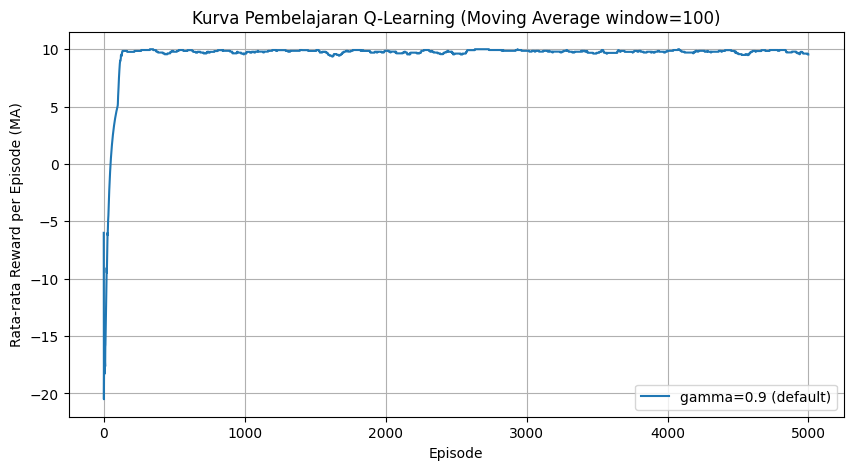

In [5]:
# Cell 5: plot moving average reward (window 100)
def plot_moving_average(rewards, label="default", window=100):
    rewards_ma = pd.Series(rewards).rolling(window=window, min_periods=1).mean()
    plt.plot(rewards_ma, label=label)

plt.figure(figsize=(10,5))
plot_moving_average(rewards_default, label="gamma=0.9 (default)", window=100)
plt.title("Kurva Pembelajaran Q-Learning (Moving Average window=100)")
plt.xlabel("Episode")
plt.ylabel("Rata-rata Reward per Episode (MA)")
plt.grid(True)
plt.legend()
plt.show()


Kebijakan Optimal (Policy):


,StateIndex,StateName,BestActionIndex,BestAction
0,0,Rendah,1,Pesan Sedikit
1,1,Sedang,0,Pesan Banyak
2,2,Tinggi,2,Tidak Pesan


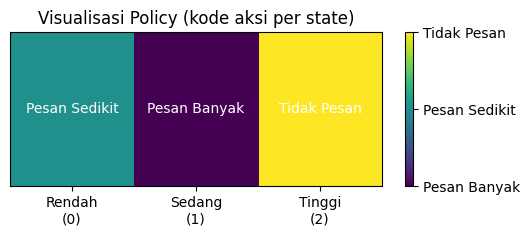

In [6]:
# Cell 6: ekstrak kebijakan optimal dan visualisasi
optimal_actions = np.argmax(Q_default, axis=1)  # untuk tiap state

policy_map = {0:"Pesan Banyak", 1:"Pesan Sedikit", 2:"Tidak Pesan"}
policy_list = [policy_map[a] for a in optimal_actions]

policy_df = pd.DataFrame({
    "StateIndex":[0,1,2],
    "StateName":["Rendah","Sedang","Tinggi"],
    "BestActionIndex":optimal_actions,
    "BestAction":policy_list
})

print("Kebijakan Optimal (Policy):")
display(policy_df)

# Visualisasi heatmap 1x3 (kode aksi)
plt.figure(figsize=(6,2))
plt.imshow(optimal_actions.reshape(1,-1), aspect="auto")
plt.title("Visualisasi Policy (kode aksi per state)")
plt.yticks([])  # hanya sumbu x penting
plt.xticks([0,1,2], ["Rendah\n(0)","Sedang\n(1)","Tinggi\n(2)"])
cbar = plt.colorbar(ticks=[0,1,2])
cbar.ax.set_yticklabels(["Pesan Banyak","Pesan Sedikit","Tidak Pesan"])
# annotate teks di tiap kotak
for x,val in enumerate(optimal_actions):
    plt.text(x, 0, policy_map[val], ha="center", va="center", color="white", fontsize=10)
plt.show()

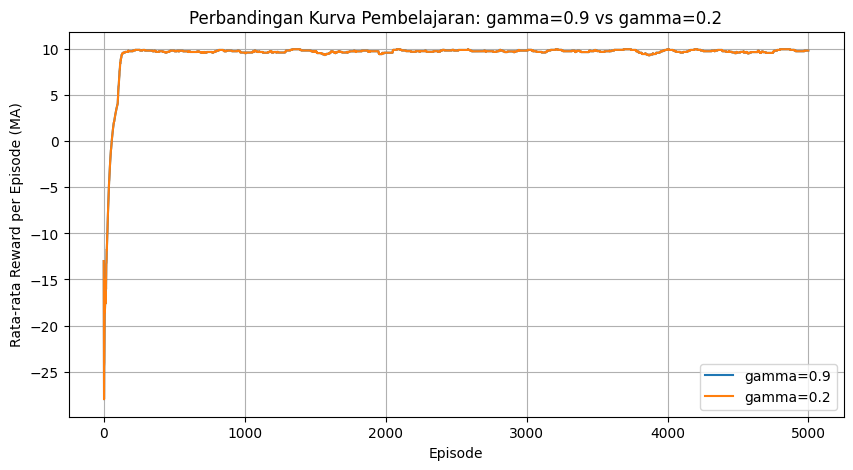

Q-Table gamma=0.9


,Pesan Banyak,Pesan Sedikit,Tidak Pesan
Rendah,7.894723,12.105263,0.894736
Sedang,7.894737,7.894737,0.894737
Tinggi,7.894737,7.894737,12.105263



Q-Table gamma=0.2


,Pesan Banyak,Pesan Sedikit,Tidak Pesan
Rendah,-2.083333,4.583333,-9.083333
Sedang,-2.083333,-2.083333,-9.083333
Tinggi,-2.083333,-2.083333,4.583333


In [7]:
# Cell 7: eksperimen gamma: high (0.9) vs low (0.2)
env1 = InventoryEnv(max_steps=10, seed=1)
Q_g_high, rewards_high = train_q_learning(env1, alpha=0.8, gamma=0.9,
                                          epsilon=1.0, min_epsilon=0.01, decay_rate=0.005,
                                          episodes=5000, max_steps=10, seed=1)

env2 = InventoryEnv(max_steps=10, seed=1)
Q_g_low, rewards_low = train_q_learning(env2, alpha=0.8, gamma=0.2,
                                         epsilon=1.0, min_epsilon=0.01, decay_rate=0.005,
                                         episodes=5000, max_steps=10, seed=1)

# Plot perbandingan moving average
plt.figure(figsize=(10,5))
plot_moving_average(rewards_high, label="gamma=0.9", window=100)
plot_moving_average(rewards_low, label="gamma=0.2", window=100)
plt.title("Perbandingan Kurva Pembelajaran: gamma=0.9 vs gamma=0.2")
plt.xlabel("Episode")
plt.ylabel("Rata-rata Reward per Episode (MA)")
plt.grid(True)
plt.legend()
plt.show()

# Print Q-tables ringkas
print("Q-Table gamma=0.9")
display(pd.DataFrame(Q_g_high, columns=["Pesan Banyak","Pesan Sedikit","Tidak Pesan"],
                     index=["Rendah","Sedang","Tinggi"]))
print("\nQ-Table gamma=0.2")
display(pd.DataFrame(Q_g_low, columns=["Pesan Banyak","Pesan Sedikit","Tidak Pesan"],
                     index=["Rendah","Sedang","Tinggi"]))


In [8]:
# Cell 8: analisis numerik sederhana untuk laporan
def convergence_episode(rewards, window=100, threshold=None):
    """
    Cari episode saat moving average jadi 'stabil' (datar) 
    Heuristik: nilai MA tidak berubah signifikan dalam last window.
    threshold: toleransi perubahan (default 1e-3)
    """
    if threshold is None:
        threshold = 1e-3
    ma = pd.Series(rewards).rolling(window=window, min_periods=1).mean().values
    # cari titik dimana var dari last window < threshold
    for i in range(window, len(ma)):
        recent = ma[i-window+1:i+1]
        if np.max(recent) - np.min(recent) < threshold:
            return i  # episode index
    return None

epi_conv_default = convergence_episode(rewards_default, window=100, threshold=1e-2)
epi_conv_high = convergence_episode(rewards_high, window=100, threshold=1e-2)
epi_conv_low = convergence_episode(rewards_low, window=100, threshold=1e-2)

print("Estimasi episode konvergensi (heuristik):")
print(f"- default (gamma=0.9): {epi_conv_default}")
print(f"- gamma=0.9: {epi_conv_high}")
print(f"- gamma=0.2: {epi_conv_low}")


Estimasi episode konvergensi (heuristik):
- default (gamma=0.9): 2732
- gamma=0.9: None
- gamma=0.2: None
